<a href="https://colab.research.google.com/github/noobie-1999/Skin-Cancer-Classifier/blob/master/RainfallLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [0]:
df = pd.read_csv('/content/drive/My Drive/Rainfall Prediction Project/data/combined_csv_2.csv')

In [5]:
df.columns

Index(['Date', 'Longitude', 'Latitude', 'Elevation', 'Max Temperature',
       'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity',
       'Solar'],
      dtype='object')

In [6]:
df.Latitude.unique().shape

(253,)

In [7]:
df.Longitude.unique().shape

(17,)

In [8]:
df.Elevation.unique().shape

(54772,)

In [9]:
df[df['Longitude']==73.4375].Latitude.unique()

array([], dtype=int64)

In [10]:
df['Date']

0          73.4375
1          73.4375
2          73.4375
3          73.4375
4          73.4375
            ...   
5274619    80.6250
5274620    80.6250
5274621    80.6250
5274622    80.6250
5274623    80.6250
Name: Date, Length: 5274624, dtype: float64

In [0]:
df = df.drop(columns=["Solar"])

In [12]:
df.columns

Index(['Date', 'Longitude', 'Latitude', 'Elevation', 'Max Temperature',
       'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity'],
      dtype='object')

In [0]:
df = df.rename(columns={'Date':'Longitude','Longitude':'Latitude','Latitude':'Elevation','Elevation':'Max Temperature','Max Temperature':'Min Temperature','Min Temperature':'Precipitation','Precipitation':'Wind','Wind':'Relative Humidity','Relative Humidity':'Solar'})

In [14]:
df.columns

Index(['Longitude', 'Latitude', 'Elevation', 'Max Temperature',
       'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity',
       'Solar'],
      dtype='object')

In [15]:
df.head()

,Longitude,Latitude,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,73.4375,25.134399,378,25.938,10.058,0.0,2.576643,0.252023,15.624735
1,73.4375,25.134399,378,24.660,6.555,0.0,2.264984,0.321919,15.858560
2,73.4375,25.134399,378,22.851,5.696,0.0,2.686659,0.433333,15.908623
3,73.4375,25.134399,378,22.863,7.659,0.0,3.408720,0.392152,16.000143
4,73.4375,25.134399,378,23.757,6.847,0.0,2.448195,0.331057,16.228858


In [0]:
df = df[df['Elevation']==378]

In [17]:
df

,Longitude,Latitude,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,73.4375,25.134399,378,25.938,10.058,0.000000,2.576643,0.252023,15.624735
1,73.4375,25.134399,378,24.660,6.555,0.000000,2.264984,0.321919,15.858560
2,73.4375,25.134399,378,22.851,5.696,0.000000,2.686659,0.433333,15.908623
3,73.4375,25.134399,378,22.863,7.659,0.000000,3.408720,0.392152,16.000143
4,73.4375,25.134399,378,23.757,6.847,0.000000,2.448195,0.331057,16.228858
...,...,...,...,...,...,...,...,...,...
12923,73.4375,25.134399,378,31.039,24.313,41.298310,2.210125,0.813754,23.228179
12924,73.4375,25.134399,378,30.347,24.610,22.930524,1.924770,0.838898,10.807017
12925,73.4375,25.134399,378,33.274,24.667,26.691629,1.386035,0.788968,17.757327
12926,73.4375,25.134399,378,32.104,24.775,28.763582,0.961550,0.782874,24.035697


In [0]:
#parameters

T = 15
D = 6
N = 0
num_samples = df.shape[0]

def create_dataset():
  X = []
  y = []
  for i in range(num_samples-T):
    features = []
    label = []
    for j in range(i,i+T):
      features.append([df.iloc[i]['Max Temperature'], df.iloc[i]['Min Temperature'], df.iloc[i]['Precipitation'], df.iloc[i]['Wind'], df.iloc[i]['Relative Humidity'], df.iloc[i]['Solar']])
    label = [df.iloc[i]['Max Temperature'], df.iloc[i]['Min Temperature'], df.iloc[i]['Precipitation'], df.iloc[i]['Wind'], df.iloc[i]['Relative Humidity'], df.iloc[i]['Solar']]
    X.append(features)
    y.append(label)

  X = np.array(X)
  y = np.array(y)

  return X,y

In [0]:
X,y = create_dataset()

In [20]:
X.shape

(12913, 15, 6)

In [21]:
N = X.shape[0]
y.shape

(12913, 6)

In [0]:
def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [0]:
i = Input(shape=(T,D))
x = LSTM(15, activation='tanh')(i)
x = Dense(6, activation='relu')(x)

In [0]:
model = Model(i,x)

In [0]:
model.compile(optimizer=Adam(), loss='mse', metrics=[rmse])

In [0]:
train_num = int(N*0.7)

In [30]:
train_num

9039

In [31]:
N-train_num

3874

In [32]:
model_historu = model.fit(X[:train_num], y[:train_num], epochs=70, validation_data=(X[train_num:], y[train_num:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9039 samples, validate on 3874 samples
Epoch 1/70
9039/9039 [==============================] - 4s 465us/sample - loss: 289.2446 - rmse: 16.5307 - val_loss: 249.6353 - val_rmse: 15.3844
Epoch 2/70
9039/9039 [==============================] - 4s 424us/sample - loss: 225.0728 - rmse: 14.4722 - val_loss: 197.9046 - val_rmse: 13.6099
Epoch 3/70
9039/9039 [==============================] - 4s 405us/sample - loss: 179.6577 - rmse: 12.8172 - val_loss: 157.2664 - val_rmse: 12.0410
Epoch 4/70
9039/9039 [==============================] - 4s 422us/sample - loss: 140.0995 - rmse: 11.1756 - val_loss: 114.6344 - val_rmse: 10.1562
Epoch 5/70
9039/9039 [==============================] - 4s 413us/sample - loss: 101.0000 - rmse: 9.3112 - val_loss: 83.1966 - val_rmse: 8.5391
Epoch 6/70
9039/9039 [==============================] - 4s 398us/sample - loss: 76.4504 - rmse: 7.9613 - val_loss: 63.4113 - val_rm

In [0]:
model_history = model.fit(X[:train_num], y[:train_num], epochs=50, validation_data=(X[train_num:], y[train_num:]))

Train on 12783 samples, validate on 130 samples
Epoch 1/50
12783/12783 [==============================] - 6s 484us/sample - loss: 279.2831 - val_loss: 319.3115
Epoch 2/50
12783/12783 [==============================] - 5s 422us/sample - loss: 191.5689 - val_loss: 234.6184
Epoch 3/50
12783/12783 [==============================] - 5s 423us/sample - loss: 131.4395 - val_loss: 161.1151
Epoch 4/50
12783/12783 [==============================] - 5s 424us/sample - loss: 91.7885 - val_loss: 115.5957
Epoch 5/50
12783/12783 [==============================] - 5s 425us/sample - loss: 67.1896 - val_loss: 84.1291
Epoch 6/50
12783/12783 [==============================] - 5s 422us/sample - loss: 50.7798 - val_loss: 61.4404
Epoch 7/50
12783/12783 [==============================] - 5s 410us/sample - loss: 39.3145 - val_loss: 44.9566
Epoch 8/50
12783/12783 [==============================] - 5s 422us/sample - loss: 31.2650 - val_loss: 33.1050
Epoch 9/50
12783/12783 [==============================] - 6s 433u

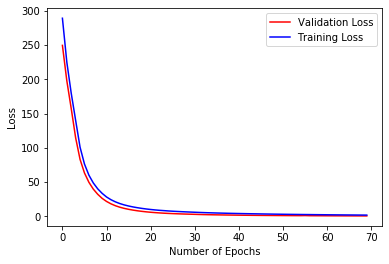

In [34]:
val_loss = model_historu.history['val_loss']
loss = model_historu.history['loss']

plt.plot(val_loss, 'r', label="Validation Loss")
plt.plot(loss, 'b', label="Training Loss")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.show()

In [0]:
testing_set = X[train_num:]
val_test_set = y[train_num:]

In [36]:
print(testing_set.shape,"\t",val_test_set.shape)

(3874, 15, 6) 	 (3874, 6)


In [0]:
my_set = testing_set[0][:,2]

In [0]:
for i in range(1,testing_set.shape[0]):
  np.append(my_set, testing_set[i][:,2])

In [39]:
index = -34
print("Predicted Rainfall: ",model.predict(X[index].reshape(1, T, D))[0][2])
print("Actual Rainfall: ",y[index][2])

Predicted Rainfall:  0.032904148
Actual Rainfall:  0.0


In [0]:
actual_rainfall = []
predicted_rainfall = []

for i in range(testing_set.shape[0]):
  actual_rainfall.append(val_test_set[i][2])
  predicted_rainfall.append(model.predict(testing_set[i].reshape(-1, T, D))[0][2])

In [0]:
actual_rainfall

[0.0,
 0.0411987456,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0017166132,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0034332264000000003,
 0.0017166132,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.5037531919999998,
 0.08239752,
 0.00686646,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0034332264000000003,
 0.0,
 0.0,
 0.0411987384,
 0.0274658328,
 0.0,
 0.0,
 0.0017166132,
 0.0,
 0.0,
 0.0034332264000000003,
 0.0034332264000000003,
 0.0,
 0.0,
 0.0188827452,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0017166132,
 0.0,
 0.0034332264000000003,
 0.0,
 0.0,
 0.0017166132,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0961303608,
 0.024032592,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.127029492,
 0.0,
 0.0,
 0.01373292,
 0.0205993584,
 0.024032592,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0017166132,
 0.0,
 0.0,
 0.0,
 0.537299712,
 0.0,
 0.0017166132,
 0.0,
 0.0,

In [0]:
predicted_rainfall

[0.021379948,
 0.068362236,
 -0.029243946,
 -0.027490616,
 -0.10032177,
 -0.026294231,
 0.03507662,
 0.06428623,
 -0.053126335,
 9.393692e-05,
 -0.042243958,
 -0.01442337,
 -0.030019283,
 0.15346146,
 0.08742666,
 -0.015255451,
 0.035598755,
 0.06872368,
 0.090286255,
 -0.0038247108,
 0.0023479462,
 0.0021300316,
 0.05141306,
 0.073523045,
 -0.036128044,
 0.082074165,
 0.06963444,
 0.04065752,
 0.024952412,
 0.18060207,
 -0.034706116,
 -0.030109882,
 0.042958736,
 0.031134605,
 0.06688452,
 0.08219719,
 0.07787514,
 0.022433758,
 -0.031401634,
 -0.06482983,
 0.019224644,
 1.5268345,
 0.12815332,
 0.0035963058,
 0.042815685,
 -0.014507771,
 -0.007733345,
 -0.0008955002,
 0.029093266,
 -0.031885147,
 -0.017334938,
 -0.057122707,
 -0.029808998,
 -0.058151245,
 -0.085511684,
 -0.041329384,
 0.13500738,
 0.07347059,
 0.017178535,
 -0.04020071,
 0.014151096,
 -0.00046300888,
 0.04944992,
 0.024179935,
 -0.034080982,
 -0.03493023,
 0.039815426,
 0.09126854,
 -0.0076298714,
 -0.031058788,
 -0.

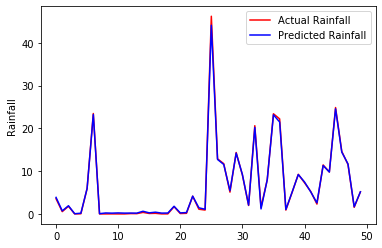

In [46]:
plt.plot(actual_rainfall[-400:-350], 'r', label="Actual Rainfall")
plt.plot(predicted_rainfall[-400:-350], 'b', label="Predicted Rainfall")
plt.ylabel("Rainfall")
plt.legend()
plt.show()

In [0]:
series = []
for i in range(df.shape[0]-2000,df.shape[0]-1500):
  series.append([df.iloc[i]['Max Temperature'], df.iloc[i]['Min Temperature'], df.iloc[i]['Precipitation'], df.iloc[i]['Wind'], df.iloc[i]['Relative Humidity'], df.iloc[i]['Solar']])


In [0]:
series = np.array(series)

In [63]:
series.shape

(500, 6)

In [0]:
predictions = np.array(series[:15])

In [0]:

for i in range(len(series)-T):
  curr_X = predictions[-T:]
  predictions = np.append(predictions, model.predict(np.array(curr_X).reshape(1,15,6))[0])
  predictions = predictions.reshape(-1, 6)

In [66]:
predictions.shape

(500, 6)

In [0]:
actual_rainfall = series[:,2]
predicted_rainfall = predictions[:,2]

In [68]:
actual_rainfall.shape

(500,)

In [58]:
predicted_rainfall

array([0.        , 0.        , 0.        , 0.        , 0.00171661,
       0.        , 0.        , 0.        , 0.        , 0.15792851,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

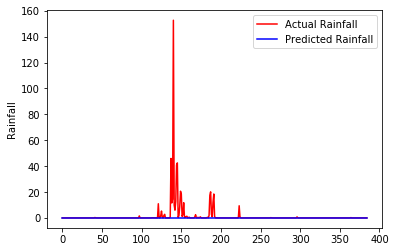

In [70]:
plt.plot(actual_rainfall[15:400], 'r', label="Actual Rainfall")
plt.plot(predicted_rainfall[15:400], 'b', label="Predicted Rainfall")
plt.legend()
plt.ylabel("Rainfall")
plt.show()

In [72]:
!git init

Initialized empty Git repository in /content/.git/


In [0]:
!git config  --global user.email "ujjwalsinha73@gmail.com"
!git config  --global user.name "noobie_1999"

In [79]:
!git add "RainfallLSTM.ipynb"

fatal: pathspec 'RainfallLSTM.ipynb' did not match any files
